In [1]:
import torch
import numpy as np

def generate_logistic_data(num_samples=10000, r_range=(2.5, 4.0)):
    r_vals = np.random.uniform(r_range[0], r_range[1], size=(num_samples,))
    x_vals = np.random.uniform(0, 1, size=(num_samples,))
    x_next = r_vals * x_vals * (1 - x_vals)

    X = np.stack([r_vals, x_vals], axis=1)  # Shape: (num_samples, 2)
    y = x_next  # Shape: (num_samples,)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)


In [2]:
import numpy as np
import torch

def generate_logistic_map_data(n_samples=10000):
    r_values = np.random.uniform(2.5, 4.0, size=n_samples)      # Chaotic regime
    x_values = np.random.uniform(0.0, 1.0, size=n_samples)
    y_values = r_values * x_values * (1 - x_values)             # Logistic map function

    # Stack r and x into input pairs
    inputs = np.stack([x_values, r_values], axis=1)             # Shape: [n_samples, 2]
    targets = y_values[:, np.newaxis]                           # Shape: [n_samples, 1]

    # Convert to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    targets = torch.tensor(targets, dtype=torch.float32)

    return inputs, targets

In [3]:
from torch.utils.data import DataLoader, TensorDataset

inputs, targets = generate_logistic_map_data()
dataset = TensorDataset(inputs, targets)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [4]:
import torch.nn as nn

class LogisticMapApproximator(nn.Module):
    def __init__(self):
        super(LogisticMapApproximator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),   # Input: [r, x_n]
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)    # Output: predicted x_{n+1}
        )

    def forward(self, x):
        return self.model(x)

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

def train_model(model, train_loader, epochs=100, lr=0.001):
    criterion = nn.MSELoss()                    # Use MSE for regression
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.6f}")

In [9]:
class LogisticMapNN(nn.Module):
    def __init__(self):
        super(LogisticMapNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),    # input: [xₜ, r]
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)     # output: xₜ₊₁
        )

    def forward(self, x):
        return self.net(x)

In [13]:
model = LogisticMapNN()
train_model(model, train_loader, epochs=500, lr=0.0005)

Epoch [10/500], Loss: 0.075677
Epoch [20/500], Loss: 0.018157
Epoch [30/500], Loss: 0.010053
Epoch [40/500], Loss: 0.008919
Epoch [50/500], Loss: 0.006785
Epoch [60/500], Loss: 0.007364
Epoch [70/500], Loss: 0.004454
Epoch [80/500], Loss: 0.004678
Epoch [90/500], Loss: 0.004080
Epoch [100/500], Loss: 0.004513
Epoch [110/500], Loss: 0.003876
Epoch [120/500], Loss: 0.003699
Epoch [130/500], Loss: 0.003710
Epoch [140/500], Loss: 0.003676
Epoch [150/500], Loss: 0.003772
Epoch [160/500], Loss: 0.003712
Epoch [170/500], Loss: 0.003634
Epoch [180/500], Loss: 0.003225
Epoch [190/500], Loss: 0.004327
Epoch [200/500], Loss: 0.003536
Epoch [210/500], Loss: 0.003385
Epoch [220/500], Loss: 0.003313
Epoch [230/500], Loss: 0.004408
Epoch [240/500], Loss: 0.003542
Epoch [250/500], Loss: 0.003662
Epoch [260/500], Loss: 0.003566
Epoch [270/500], Loss: 0.002822
Epoch [280/500], Loss: 0.003769
Epoch [290/500], Loss: 0.003163
Epoch [300/500], Loss: 0.003249
Epoch [310/500], Loss: 0.003258
Epoch [320/500], 

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'inputs' and 'targets' are torch tensors from your dataset
x_vals = inputs[:, 0].detach().cpu().numpy()
r_vals = inputs[:, 1].detach().cpu().numpy()
x_true = targets.detach().cpu().numpy()
x_pred = model(inputs).detach().cpu().numpy()

def plot_by_r_range(x_vals, x_true, x_pred, r_vals):
    ranges = [(2.5, 3.0), (3.0, 3.5), (3.5, 4.0)]
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for i, (r_min, r_max) in enumerate(ranges):
        mask = (r_vals >= r_min) & (r_vals < r_max)

        axs[i].scatter(x_vals[mask], x_true[mask], label="True", s=2, alpha=0.6)
        axs[i].scatter(x_vals[mask], x_pred[mask], label="Predicted", s=2, alpha=0.6)
        axs[i].set_title(f"r ∈ [{r_min}, {r_max})")
        axs[i].set_xlabel("x")
        axs[i].set_ylabel("x_next" if i == 0 else "")
        axs[i].legend()

    fig.suptitle("Logistic Map Approximation: True vs Predicted by r-value")
    plt.tight_layout()
    plt.show()

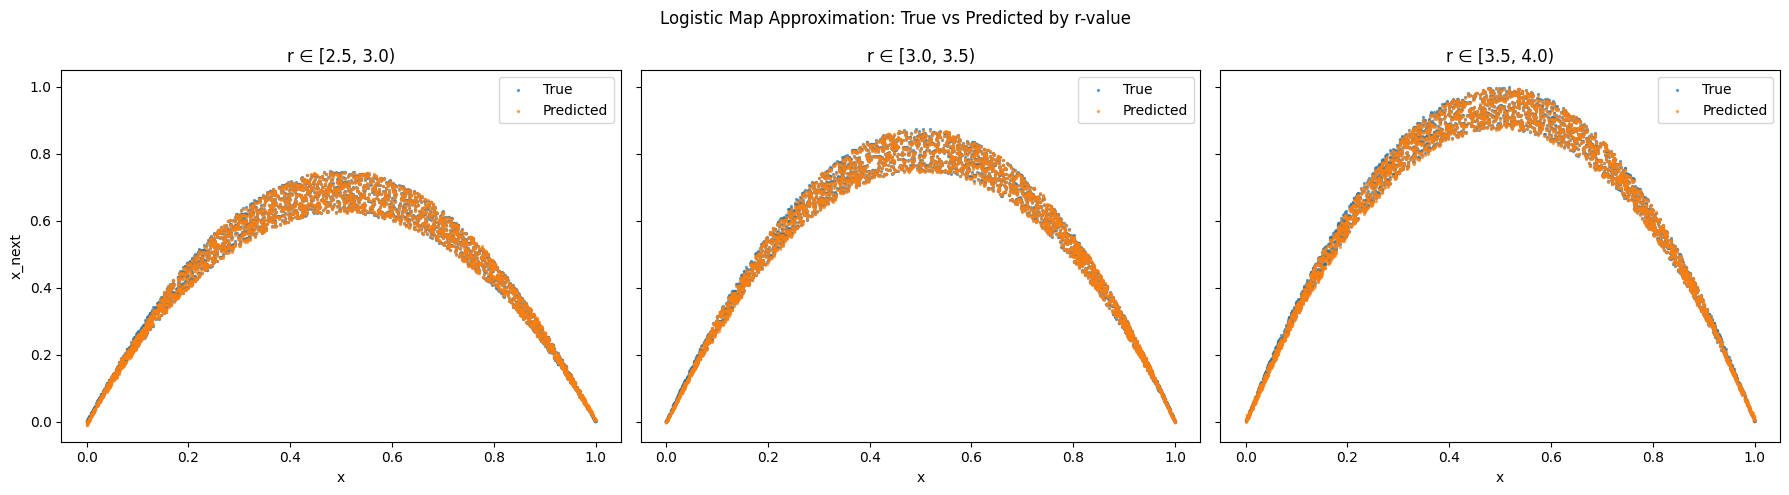

In [21]:
plot_by_r_range(x_vals, x_true, x_pred, r_vals)

In [22]:
torch.save(model.state_dict(), "logistic_map_approximator.pth")